In [69]:
import wget
#download an example pdb file
url = 'https://files.rcsb.org/download/1EEI.pdb'
filename = wget.download(url)

-1 / unknown

In [73]:
filename = './1eei (1).pdb'

Index(['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F',
       'P', 'S', 'T', 'W', 'Y', 'V'],
      dtype='object')
566
    0     1     2     3     4     5     6      7      8      9    ...   556  \
A  4.35  0.61  1.18  1.56  1.00  0.77  0.37  0.357   52.6   16.0  ...   6.0   
R  4.38  0.60  0.20  0.45  0.52  0.72  0.84  0.529  109.1  -70.0  ...  19.0   
N  4.75  0.06  0.23  0.27  0.35  0.55  0.97  0.463   75.7  -74.0  ...  12.0   
D  4.76  0.46  0.05  0.14  0.44  0.65  0.97  0.511   68.4  -78.0  ...  12.0   
C  4.65  1.07  1.89  1.23  0.06  0.65  0.84  0.346   68.3  168.0  ...   6.0   

      557   558   559     560   561     562  563     564    565  
A   6.000   6.0   6.0  12.000  6.00  12.000  0.0   6.000  0.000  
R  31.444  20.0  38.0  45.000  5.00  23.343  0.0  10.667  4.200  
N  16.500  14.0  20.0  33.007  6.60  27.708  0.0  10.000  3.000  
D  16.400  12.0  20.0  34.000  6.80  28.634  0.0  10.400  2.969  
C  16.670  12.0  22.0  28.000  9.33  28.000  0.0  11.3

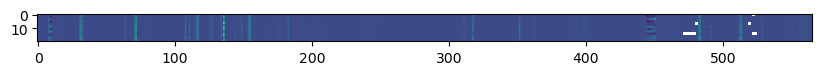

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
aaproperties = pd.read_csv('./aaindex1.csv', header=0)
aaproperties.drop( [ 'description' , 'reference'  ], axis=1, inplace=True)

print(aaproperties.columns)
print( len(aaproperties) )

#one hot encoding
onehot= np.fill_diagonal(np.zeros((20,20)), 1)
onehot = pd.DataFrame(onehot)
#change to integers instead of bool
onehot = onehot.astype(int)
#append to the dataframe
aaproperties = aaproperties.T
aaproperties = pd.concat([aaproperties, onehot ], axis=1)

print(aaproperties.head())

plt.figure( figsize=(10,10) )
plt.imshow(aaproperties)


In [75]:
from Bio import PDB
import warnings
from matplotlib import pyplot as plt
import numpy as np
#import torch
#import pydssp
from Bio.PDB import PDBParser   
import numpy as np
filename = './1eei.pdb'
    
def read_pdb(filename):
    #silence all warnings
    warnings.filterwarnings('ignore')

    with warnings.catch_warnings():        
        parser = PDB.PDBParser()
        structure = parser.get_structure(filename, filename)
        chains = [ c for c in structure.get_chains()]
        return chains

#return the phi, psi, and omega angles for each residue in a chain
def get_angles(chain):

    phi_psi_angles = []

    chain = [ r for r in chain if PDB.is_aa(r)]
    #sliding window of 3 residues
    polypeptides = [ chain[i:i+3] for i in range(len(chain)) if len(chain[i:i+4]) >= 3]
    #translate to single letter code
    print(polypeptides)


    for poly_index, poly in enumerate(polypeptides):
        phi = None
        psi = None

        if len(poly) >= 3:
            c_minus_1 = poly[len(poly) - 3]["C"].get_vector()
            n = poly[len(poly) - 2]["N"].get_vector()
            ca = poly[len(poly) - 2]["CA"].get_vector()
            c = poly[len(poly) - 2]["C"].get_vector()

            # Calculate phi angle
            phi = PDB.calc_dihedral(c_minus_1, n, ca, c)
            n = poly[len(poly) - 2]["N"].get_vector()
            ca = poly[len(poly) - 2]["CA"].get_vector()
            c = poly[len(poly) - 2]["C"].get_vector()
            n_plus_1 = poly[len(poly) - 1]["N"].get_vector()

            # Calculate psi angle
            psi = PDB.calc_dihedral(n, ca, c, n_plus_1)
        residue = poly[0]
        residue_id = residue.get_full_id()

        phi_psi_angles.append({
            "Chain": residue_id[2],
            "Residue_Number": residue_id[3][1],
            "Residue_Name": residue.get_resname(),
            #translate 3 letter to 1 letter code
            "single_letter_code": PDB.Polypeptide.three_to_one(residue.get_resname()),
            "Phi_Angle": phi,
            "Psi_Angle": psi
        })
    #transform phi and psi angles into a dataframe
    phi_psi_angles = pd.DataFrame(phi_psi_angles)
    #transform the residue names into single letter code
    return phi_psi_angles    

def get_contact_points(chain, distance):
    contact_mat = np.zeros((len(chain), len(chain)))
    for i,r1 in enumerate(chain):
        for j,r2 in enumerate(chain):
            if i< j:
                if 'CA' in r1 and 'CA' in r2:
                    if r1['CA'] - r2['CA'] < distance:
                        contact_mat[i,j] =  r1['CA'] - r2['CA']
    contact_mat = contact_mat + contact_mat.T
    return contact_mat

def get_backbone(chain):
    contact_mat = np.zeros((len(chain), len(chain)))
    #fill diagonal with 1s
    np.fill_diagonal(contact_mat, 1)
    return contact_mat

def ret_hbonds(chain , verbose = False):
    #loop through all atoms in a structure
    struct = PDBParser().get_structure('1eei', filename)
    typeindex = {'N':0, 'O':1, 'C':2}
    #get the number of atoms in the chain
    #create a numpy array of zeros with the shape of (1, length, atoms, xyz)
    output = np.zeros((1, len(chain), len(typeindex), 3 ))
    for c, res in enumerate(chain):
        atoms = res.get_atoms()
        for at,atom in enumerate(atoms):
            if atom.get_name() in typeindex:
                output[ 0, c ,  typeindex[atom.get_name()] , : ]  = atom.get_coord()
    output = torch.tensor(output)
    if verbose:
        print(output.shape)
    mat =  pydssp.get_hbond_map(output[0])
    return mat

#add the amino acid properties to the angles dataframe
#one hot encode the amino acid properties
def add_aaproperties(angles, aaproperties = aaproperties):
    
    nodeprops = angles.merge(aaproperties, left_on='single_letter_code', right_index=True, how='left')
    nodeprops = nodeprops.dropna()

    #generate 1 hot encoding for each amino acid

    one_hot = pd.get_dummies(nodeprops['single_letter_code']).astype(int)
    nodeprops = nodeprops.join(one_hot)
    nodeprops = nodeprops.drop(columns=['single_letter_code'])

    return nodeprops



In [76]:
from prody import *
from pylab import *

def anm_analysis(filename):
    prot = parsePDB( filename)
    calphas2 = prot.select('calpha')
    anm = ANM('ANM analysis')
    anm.buildHessian(calphas2)
    anm.calcModes()

    cov = anm.getCovariance()
    cov[ cov < 0] = -cov[ cov < 0]

    logcov = np.log(cov)
    #get the top 10% of the covariance matrix
    top = np.percentile(logcov, 90)
    logcov[ logcov < top] = 0
    return logcov

cov = anm_analysis(filename)
print(cov.shape)

plt.imshow(cov)
plt.colorbar()
plt.show()

#print the number of 0 entries
print( np.sum(cov != 0) /np.sum(cov == 0))


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte

In [ ]:
#create features from a monomer pdb file
from scipy import sparse
def create_features(monomerpdb, aaproperties, verbose = False):
    chain = read_pdb(monomerpdb)[0]
    angles = get_angles(chain)
    angles = add_aaproperties(angles, aaproperties)
    angles = angles.dropna()
    angles = angles.reset_index(drop=True)
    angles = angles.set_index(['Chain', 'Residue_Number'])
    angles = angles.sort_index()
    angles = angles.dropna()
    angles = angles.reset_index()
    angles = angles.drop(['Chain', 'Residue_Number' , 'Residue_Name'], axis=1)
    print( angles.columns)
    angles = angles.values
    angles = angles.astype('float32')
    if verbose:
        print(angles.shape)
    contact_points = get_contact_points(chain, 8)
    if verbose:
        print(contact_points.shape)
    #hbond_mat = ret_hbonds(chain, verbose)
    
    #return the angles, amino acid properties, contact points, and hydrogen bonds
    #backbone is just the amino acid chain
    backbone = get_backbone(chain)
    springmat = anm_analysis(monomerpdb)

    #change the contac matrices to sparse matrices
    contact_points = sparse.csr_matrix(contact_points)
    springmat = sparse.csr_matrix(springmat)
    backbone = sparse.csr_matrix(backbone)
    
    return angles, contact_points, springmat , backbone




In [77]:

#write a function to store sparse matrices in an hdf5 file for many pdb files
import h5py
def store_features( pdbfiles, aaproperties, filename, verbose = False):
    #create a hdf5 file
    with h5py.File(filename, 'pdbfiles') as f:
        for pdbfile in pdbfiles:
            if verbose:
                print(pdbfile)
            angles, contact_points, springmat, backbone = create_features(pdbfile, aaproperties, verbose)
            #store the features in the hdf5 file
            f.create_dataset(pdbfile + '_angles', data=angles)
            f.create_dataset(pdbfile + '_contact_points', data=contact_points)
            f.create_dataset(pdbfile + '_springmat', data=springmat)
            f.create_dataset(pdbfile + '_backbone', data=backbone)

In [79]:
features = create_features('1eei (1).pdb', aaproperties, verbose = True)

@> 4630 atoms and 1 coordinate set(s) were parsed in 0.08s.


[[<Residue THR het=  resseq=1 icode= >, <Residue PRO het=  resseq=2 icode= >, <Residue GLN het=  resseq=3 icode= >], [<Residue PRO het=  resseq=2 icode= >, <Residue GLN het=  resseq=3 icode= >, <Residue ASN het=  resseq=4 icode= >], [<Residue GLN het=  resseq=3 icode= >, <Residue ASN het=  resseq=4 icode= >, <Residue ILE het=  resseq=5 icode= >], [<Residue ASN het=  resseq=4 icode= >, <Residue ILE het=  resseq=5 icode= >, <Residue THR het=  resseq=6 icode= >], [<Residue ILE het=  resseq=5 icode= >, <Residue THR het=  resseq=6 icode= >, <Residue ASP het=  resseq=7 icode= >], [<Residue THR het=  resseq=6 icode= >, <Residue ASP het=  resseq=7 icode= >, <Residue LEU het=  resseq=8 icode= >], [<Residue ASP het=  resseq=7 icode= >, <Residue LEU het=  resseq=8 icode= >, <Residue CYS het=  resseq=9 icode= >], [<Residue LEU het=  resseq=8 icode= >, <Residue CYS het=  resseq=9 icode= >, <Residue ALA het=  resseq=10 icode= >], [<Residue CYS het=  resseq=9 icode= >, <Residue ALA het=  resseq=10 ic

@> Hessian was built in 0.25s.
@> 20 modes were calculated in 0.73s.


In [80]:
import networkx as nx
#transform the contact matrices into a networkx multigraph 
import colour 

def tensor_to_multigraph(adjacency_tensor):
    # Initialize a MultiGraph
    G = nx.MultiGraph()
    num_nodes = adjacency_tensor.shape[1]
    G.add_nodes_from(range(num_nodes))
    colors = [ c.hex_l for c in  colour.Color('red').range_to(colour.Color('green'), adjacency_tensor.shape[0]) ]
    # Iterate through the adjacency matrices in the tensor
    for i, adj_matrix in enumerate(adjacency_tensor):
        # Add nodes to the MultiGraph
        # Iterate through the rows and columns of the adjacency matrix to add edges
        for row in range(num_nodes):
            for col in range(num_nodes):
                if adjacency_tensor[i,row, col] != 0:
                    # Add an edge with weight (if needed) to the MultiGraph
                    G.add_edge(row, col, weight=adjacency_tensor[i,row, col] , color = colors[i],  layer= i )
    return G

def draw_graph(G , adjacency_tensor ):
    # Get the color of each edge
    edge_colors = [e[2]['color'] for e in G.edges(data=True)]
    # Get the weight of each edge
    edge_weights = [e[2]['weight'] for e in G.edges(data=True)]
    # Get the positions of each node in the graph
    pos = nx.spring_layout(G)
    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, node_color='black', node_size=100)
    # Draw the edges
    for i in range(0, adjacency_tensor.shape[0]):
        # Draw the edges with a curved arc
        nx.draw_networkx_edges( G, pos, width=edge_weights, edge_color=edge_colors, edgelist=[e for e in G.edges(data=True) if e[2]['layer'] == layer], connectionstyle='arc3, rad = 0.1')
    plt.show()
G = tensor_to_multigraph(adjacency_tensor)
print(G)
draw_graph(G, adjacency_tensor=adjacency_tensor)


NameError: name 'adjacency_tensor' is not defined

In [81]:
import pandas as pd
cols = 'repId_isDark_nMem_repLen_avgLen_repPlddt_avgPlddt_LCAtaxId'.split('_')
repdf = pd.read_table( './afdbclusters/2-repId_isDark_nMem_repLen_avgLen_repPlddt_avgPlddt_LCAtaxId.tsv')
repdf.columns = cols
print(repdf.head())

        repId  isDark  nMem  repLen   avgLen  repPlddt  avgPlddt  LCAtaxId
0  A0A6M1CKG1       0     3     122  122.667     96.06   88.1467     91347
1  A0A4Q3Q6P1       1     3     117  113.333     71.94   67.8333     80864
2  A0A4V3EFQ4       0     3     153  156.000     68.56   58.8533    131567
3  A0A4V3EKB1       1     3      51   51.000     62.62   62.7700      1883
4  A0A4V3EP89       0     2      96   94.500     70.88   72.1900   2593676


In [82]:
import multiprocessing as mp
import tqdm
import os
import numpy as np
import wget 

def download_pdb(rep ,structdir = './structs/'):
    url = f'https://alphafold.ebi.ac.uk/files/AF-{rep}-F1-model_v4.pdb'
    #check if file exists
    if os.path.exists( structdir + rep + '.pdb'):
        return self.raw_dir + rep + '.pdb'
    filename = wget.download(url, out=structdir + rep + '.pdb')
    return filename

def download(repdf , nreps = 100 , structdir = './structs/'):
    if not os.path.exists(structdir):
        os.makedirs(structdir)
            
    reps = repdf.repId.unique()
    if nreps:
        #select a random sample of representatives
        reps = np.random.choice(reps, nreps)
    with mp.Pool(20) as p:
        filenames = p.map(download_pdb, tqdm.tqdm(reps))
    return filenames

In [83]:

download(repdf, nreps = 100 , structdir = './structs/' )


100%|████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 46076.06it/s]

-1 / unknown

-1 / unknown

['./structs/A0A7W8FPZ4.pdb',
 './structs/A0A836H3G1.pdb',
 './structs/A0A6N6N288.pdb',
 './structs/A0A7V6MV81.pdb',
 './structs/A0A2P6NH54.pdb',
 './structs/A0A2H6BES3.pdb',
 './structs/A0A662XLV5.pdb',
 './structs/A0A183F916.pdb',
 './structs/B1C2J2.pdb',
 './structs/Q4MZB1.pdb',
 './structs/A0A1E7XWI7.pdb',
 './structs/A0A6N3EIL0.pdb',
 './structs/A0A2D5FPW9.pdb',
 './structs/A0A2H9ZQJ2.pdb',
 './structs/A0A183ABH2.pdb',
 './structs/A0A6G0U9Z6.pdb',
 './structs/A0A1N2QHG7.pdb',
 './structs/A0A0D2WJQ4.pdb',
 './structs/A0A5C6Y2C3.pdb',
 './structs/A0A7C4AGE0.pdb',
 './structs/J4THW0.pdb',
 './structs/M0DLE1.pdb',
 './structs/A0A1S2MDU8.pdb',
 './structs/A0A354FKR7.pdb',
 './structs/A0A4W4GYV7.pdb',
 './structs/A0A1J4WQZ0.pdb',
 './structs/A0A0A9XWZ4.pdb',
 './structs/A0A6V8Q7P0.pdb',
 './structs/A0A059F5U2.pdb',
 './structs/A0A356IPQ5.pdb',
 './structs/A0A077ZVP0.pdb',
 './structs/A0A6P4YWR4.pdb',
 './structs/A0A672S2M1.pdb',
 './structs/A0A495N293.pdb',
 './structs/A0A7J5XBR9.pdb',
 

In [84]:
# Standard libraries
import os

# For downloading pre-trained models
import urllib.request
from urllib.error import HTTPError

# PyTorch Lightning
import pytorch_lightning as L

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# PyTorch geometric
import torch_geometric
import torch_geometric.data as geom_data
import torch_geometric.nn as geom_nn

# PL callbacks
from pytorch_lightning.callbacks import ModelCheckpoint
from torch import Tensor

AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 64
# Path to the folder where the datasets are/should be downloaded
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/GNNs/")

# Setting the seed
L.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Seed set to 42


In [85]:
import torch
from torch_geometric.data import Data, Dataset


from torch_geometric.data import HeteroData
import scipy.sparse
import torch

def sparse2pairs(sparsemat):
    sparsemat = scipy.sparse.find(sparsemat)
    return np.vstack([sparsemat[0],sparsemat[1]])

def struct2pyg(pdbchain , aaproperties= aaproperties):
    data = HeteroData()
    #transform a structure chain into a pytorch geometric graph
    #get the adjacency matrices
    angles, contact_points, springmat , backbone = create_features(pdbchain, aaproperties)
    
    #get the node features
    angles = get_angles(pdbchain)
    angles = add_aaproperties(angles, aaproperties)
    angles = angles.set_index('Residue_Number')
    angles = angles.sort_index()
    angles = angles.drop(['Residue_Name', 'single_letter_code'], axis=1)
    angles = angles.drop(['Chain'], axis=1)
    angles = torch.tensor(angles.values, dtype=torch.float)
    data['res'].x = angles

    
    #get the edge features
    data['res','backbone','res'].edge_attr = torch.tensor(backbone.data, dtype=torch.float)
    data['res','contact_points', 'res'].edge_attr = torch.tensor(contact_points.data, dtype=torch.float)
    data['res','hbond_mat', 'res'].edge_attr = torch.tensor(hbond_mat.data, dtype=torch.float)
    data['res','spring_mat', 'res'].edge_attr = torch.tensor(springmat.data, dtype=torch.float)

    backbone = sparse2pairs(backbone)
    contact_points = sparse2pairs(contact_points)
    hbond_mat = sparse2pairs(hbond_mat)
    springmat = sparse2pairs(springmat)

    #get the adjacency matrices into tensors
    data['res','backbone','res'].edge_index = torch.tensor(backbone,  dtype=torch.long )
    data['res','contact_points', 'res'].edge_index = torch.tensor(contact_points,  dtype=torch.long )    
    data['res','hbond_mat', 'res'].edge_index = torch.tensor(hbond_mat,  dtype=torch.long )
    data['res','spring_mat', 'res'].edge_index = torch.tensor(springmat,  dtype=torch.long )

    #add self loops
    data['res','backbone','res'].edge_index = torch_geometric.utils.add_self_loops(data['res','backbone','res'].edge_index)[0]
    data['res','contact_points', 'res'].edge_index = torch_geometric.utils.add_self_loops(data['res','contact_points', 'res'].edge_index)[0]
    data['res','hbond_mat', 'res'].edge_index = torch_geometric.utils.add_self_loops(data['res','hbond_mat', 'res'].edge_index)[0]

    #normalize features

    data['res'].x = torch_geometric.utils.normalize_features(data['res'].x)
    data['res','backbone','res'].edge_attr = torch_geometric.utils.normalize_edge_attr(data['res','backbone','res'].edge_attr)
    data['res','contact_points', 'res'].edge_attr = torch_geometric.utils.normalize_edge_attr(data['res','contact_points', 'res'].edge_attr)
    data['res','hbond_mat', 'res'].edge_attr = torch_geometric.utils.normalize_edge_attr(data['res','hbond_mat', 'res'].edge_attr)

    return data

#create a function to store the pytorch geometric data in a hdf5 file

def store_pyg(pdbfiles, aaproperties, filename, verbose = False):
    with h5py.File(filename , mode = 'w') as f:
        for pdbfile in pdbfiles:
      
            if verbose:
                print(pdbfile)
            data = struct2pyg(pdbfile, aaproperties)
            f.create_group(pdbfile)
            for key in data.keys():
                f.create_dataset(pdbfile + '/' + key, data=data[key])



class StructureDataset(Dataset):
    def __init__(self, h5dataset):
        super().__init__()
        #keys should be the structures
        self.structures = h5dataset

    def __len__(self):
        return len(self.structures)

    def __getitem__(self, idx):
        structure = self.structures[idx]
        data = {}
        for key in structure.keys():
            data[key] = torch.tensor(structure[key])
        #return pytorch geometric heterograph
        data = HeteroData(data)
        return data
    


#create pytorch lightning dataloaders
    
from torch_geometric.data import DataLoader
import pytorch_lightning as pl
class StructureDataModule(pl.LightningDataModule):
    def __init__(self, structuredir, batch_size=32):
        super().__init__()
        self.structuredir = structuredir
        self.batch_size = batch_size
        self.dataset = StructureDataset(self.structuredir)

    def setup(self, stage=None):
        #split the dataset into training, validation, and test sets
        self.train_dataset, self.val_dataset, self.test_dataset = torch.utils.data.random_split(self.dataset, [int(0.8*len(self.dataset)), int(0.1*len(self.dataset)), int(0.1*len(self.dataset))])

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

In [86]:
#create the h5 dataset from the pdb files
import glob
pdbfiles = glob.glob('./structs/*.pdb')
store_pyg(pdbfiles, aaproperties, filename, verbose = False)


[[<Residue MET het=  resseq=1 icode= >, <Residue ASP het=  resseq=2 icode= >, <Residue ARG het=  resseq=3 icode= >], [<Residue ASP het=  resseq=2 icode= >, <Residue ARG het=  resseq=3 icode= >, <Residue SER het=  resseq=4 icode= >], [<Residue ARG het=  resseq=3 icode= >, <Residue SER het=  resseq=4 icode= >, <Residue PHE het=  resseq=5 icode= >], [<Residue SER het=  resseq=4 icode= >, <Residue PHE het=  resseq=5 icode= >, <Residue GLN het=  resseq=6 icode= >], [<Residue PHE het=  resseq=5 icode= >, <Residue GLN het=  resseq=6 icode= >, <Residue SER het=  resseq=7 icode= >], [<Residue GLN het=  resseq=6 icode= >, <Residue SER het=  resseq=7 icode= >, <Residue GLY het=  resseq=8 icode= >], [<Residue SER het=  resseq=7 icode= >, <Residue GLY het=  resseq=8 icode= >, <Residue THR het=  resseq=9 icode= >], [<Residue GLY het=  resseq=8 icode= >, <Residue THR het=  resseq=9 icode= >, <Residue LEU het=  resseq=10 icode= >], [<Residue THR het=  resseq=9 icode= >, <Residue LEU het=  resseq=10 ic

@> 2178 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> Hessian was built in 0.05s.
@> 20 modes were calculated in 0.29s.


[]


KeyError: 'single_letter_code'

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv , SAGEConv , TransformerConv, GATConv
from torch import ModuleDict
#import lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer
#geometric lightning
from torch_geometric.data import DataLoader
from torch_geometric.nn.models import VGAE, GAE
from torch_geometric.data import Data
# Define autoencoder model
class encoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels , choke , nlayers=2):
        super(Autoencoder, self).__init__()
        
        #initialize the encoder and decoder as module lists

        self.layers = ModuleDict()

        #generate an hourglass shape for the encoder and decoder
        delta = (hidden_channels - choke) / (nlayers +1)
        layersizes = [ int(choke + delta * i) for i in range(0, nlayers+1) ]

        #add the first layer of the encoder
        self.layers['input'] = TransformerConv(in_channels, hidden_channels)
        for i in range(2, nlayers):
            #add the second layer of the encoder
            self.layers['layer_'+str(i)] = TransformerConv(layersizes[i], layersizes[i+1])
        
    def forward(self, x, edge_index):
        for layer in self.layers.values():
            x = F.relu(layer(x, edge_index))
        x_hat = x
        return x_hat

#try with product first?
class decoder(torch.nn.Module):
    def __init__(self, in_channels,  hidden_channels , choke , nlayers=2):
        super(Autoencoder, self).__init__()
        
        #initialize the encoder and decoder as module lists
        self.layers = ModuleDict()
        #generate an hourglass shape for the encoder and decoder
        delta = (hidden_channels - choke) / (nlayers +1)
        layersizes = [ int(choke + delta * i) for i in range(0, nlayers+1) ]
        #try to predict links between nodes
        #add the first layer of the decoder as a deep feedforward network using functional layers
        self.layers[ 'input'] = nn.Linear(hidden_channels, layersizes[0])
        for i in range(2, nlayers):
            #add the second layer of the decoder
            self.layers['layer_'+str(i)] = nn.Linear(layersizes[i], layersizes[i+1])
        #add product layer
        self.layers['output'] = nn.Linear(layersizes[nlayers], in_channels)
    
    def forward(self, x, edge_index):
        for layer in self.decoder.values():
            x = F.relu(layer(x, edge_index))
        #dot product layer
        x = torch.matmul(x, x.T)
        x_hat = x
        
        return x_hat

In [31]:

class GraphAutoencoder(pl.LightningModule):
    def __init__(self, in_channels, hidden_channels, choke, nlayers, learning_rate , encoder, decoder):
        super(GraphAutoencoder, self).__init__()
        self.encoder = encoder(in_channels, hidden_channels, choke, nlayers)
        if decoder:
            self.decoder = decoder(in_channels, hidden_channels, choke, nlayers)
        else:
            self.decoder = None
        self.model = models.VGAE(encoder, decoder)
        self.learning_rate = learning_rate

    def forward(self, x, edge_index):
        return self.model(x, edge_index)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, edge_index = batch
        x_hat = self(x, edge_index)
        # Loss from the model
        #add kl loss here
        loss = F.mse_loss(x, x_hat)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, edge_index = batch
        z, x_hat = self(x, edge_index)
        loss = F.mse_loss(x, x_hat)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, edge_index = batch
        z, x_hat = self(x, edge_index)
        loss = F.mse_loss(x, x_hat)
        self.log('test_loss', loss)
        return loss

    

In [32]:
def train_autoencoder(model_name, dataloader, **model_kwargs):
    pl.seed_everything(42)
    node_data_loader = dataloader
    # Create a PyTorch Lightning trainer
    root_dir = os.path.join(CHECKPOINT_PATH, "NodeLevel" + model_name)
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(
        default_root_dir=root_dir,
        callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
        accelerator="auto",
        devices=AVAIL_GPUS,
        max_epochs=200,
        enable_progress_bar=True,
    )  # 0 because epoch size is 1

    
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "NodeLevel%s.ckpt" % model_name)
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = NodeLevelGNN.load_from_checkpoint(pretrained_filename)
    else:
        L.seed_everything()
        model = NodeLevelGNN(
            model_name=model_name, c_in=dataset.num_node_features, c_out=dataset.num_classes, **model_kwargs
        )
        trainer.fit(model, node_data_loader, node_data_loader)
        model = NodeLevelGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on the test set
    test_result = trainer.test(model, dataloaders=node_data_loader, verbose=False)
    batch = next(iter(node_data_loader))
    batch = batch.to(model.device)
    _, train_acc = model.forward(batch, mode="train")
    _, val_acc = model.forward(batch, mode="val")
    result = {"train": train_acc, "val": val_acc, "test": test_result[0]["test_acc"]}
    return model, result

In [ ]:
#creat a dataloader
from torch_geometric.data import DataLoader


def create_dataloader(dataset, batch_size=32, shuffle=True):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)



In [ ]:
#train the model on the dataset

model, result = train_autoencoder( 'autoencoder', dataloader, in_channels=dataset.num_node_features, hidden_channels=256, choke=64, nlayers=2, learning_rate=0.001, encoder=encoder, decoder=decoder)

#save the model
torch.save(model.state_dict(), 'autoencoder.pth')

#load the model
model.load_state_dict(torch.load('autoencoder.pth'))

#evaluate the model
model.eval()
with torch.no_grad():
    for data in dataloader:
        data = data.to(model.device)
        z = model.encode(data.x, data.edge_index)
        #get the reconstruction
        recon = model.decode(z, data.edge_index)
        #get the loss
        loss = F.mse_loss(recon, data.x)
        print(loss)
        

In [ ]:
#download some examples from each cluster

#use explicit aln to comput submats

#use explicit aln to compute the compatibility matrix



In [ ]:
#train a decoder from a graph with prot alphabet to amino acid letters
#the contact mat is available for stuff from the aln 





In [ ]:
#text aligner with mafft


In [ ]:
#output links into potts model with graph 

#calculate ancestral sequences

#calculate the state transition energies

#calculate the state transition probabilities

import phylotreelib as pt
tree1 = pt.Tree.randtree(ntips=50, randomlen=True)
tree2 = tree1.copy_treeobject()
for i in range(5):
    tree2.spr()
